# image reconstruction

## Import libraries

In [1]:
import torch
import torchvision
from torch.utils.data import Dataset
from os import listdir
from os.path import join
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from math import log10
from tqdm import tqdm
import os

## Load data

In [2]:
directory_data  = './'
filename_data   = 'assignment_11_data.npz'
data            = np.load(os.path.join(directory_data, filename_data))

clean_image_train = data['label_train']
input_image_test  = data['input_test'] 
clean_image_test  = data['label_test']

In [3]:
print(clean_image_train.shape)
print(input_image_test.shape)
print(clean_image_test.shape)

(800, 128, 128)
(400, 128, 128)
(400, 128, 128)


## plot data

In [4]:
def plot_image(title, image):
    
    nRow = 6
    nCol = 4
    size = 3
    
    fig, axes = plt.subplots(nRow, nCol, figsize=(size * nCol, size * nRow))
    fig.suptitle(title, fontsize=16)

    for r in range(nRow):
        for c in range(nCol):
            k = r * nCol * 10 + c * 4 + 10
            axes[r, c].imshow(image[k], cmap='gray', vmin=0, vmax=1)

    plt.tight_layout()
    plt.show()

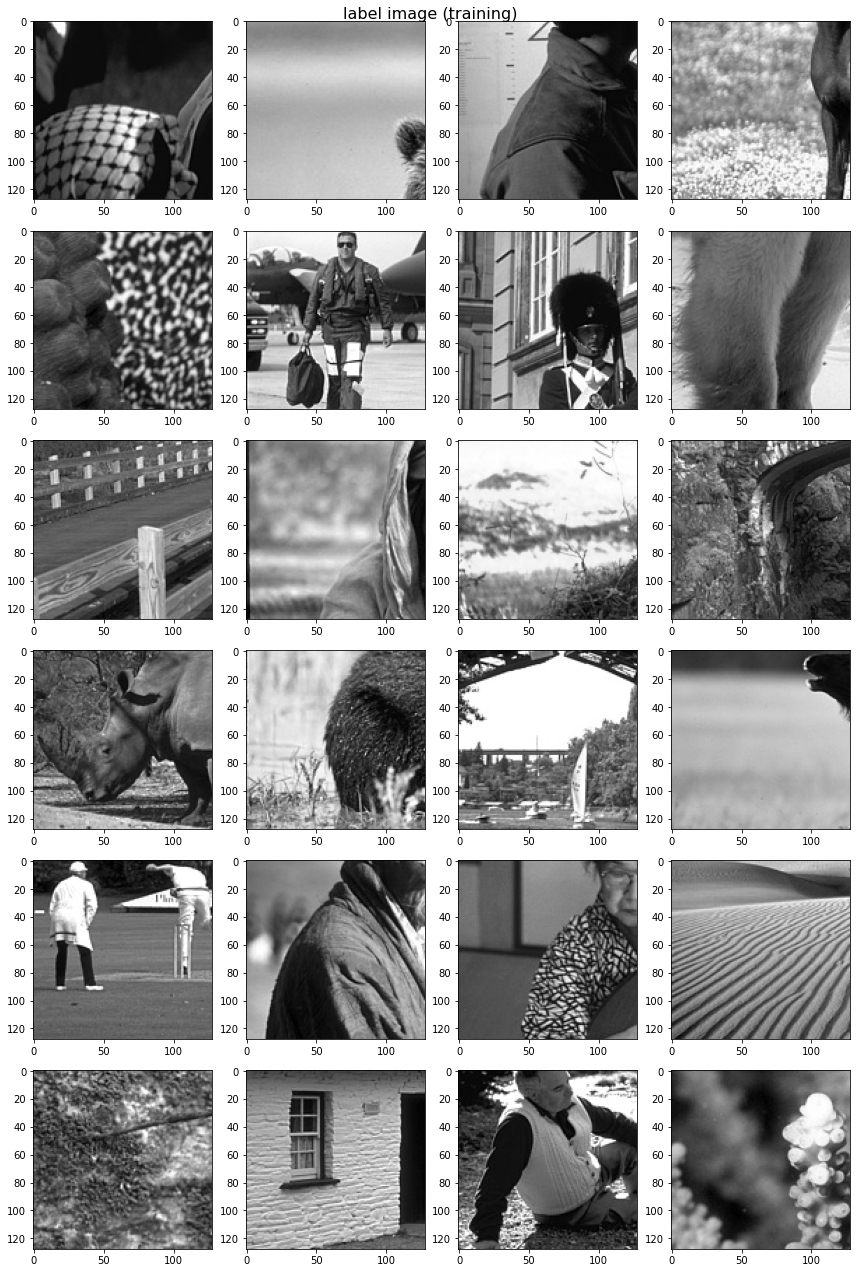

In [5]:
plot_image('label image (training)', clean_image_train)

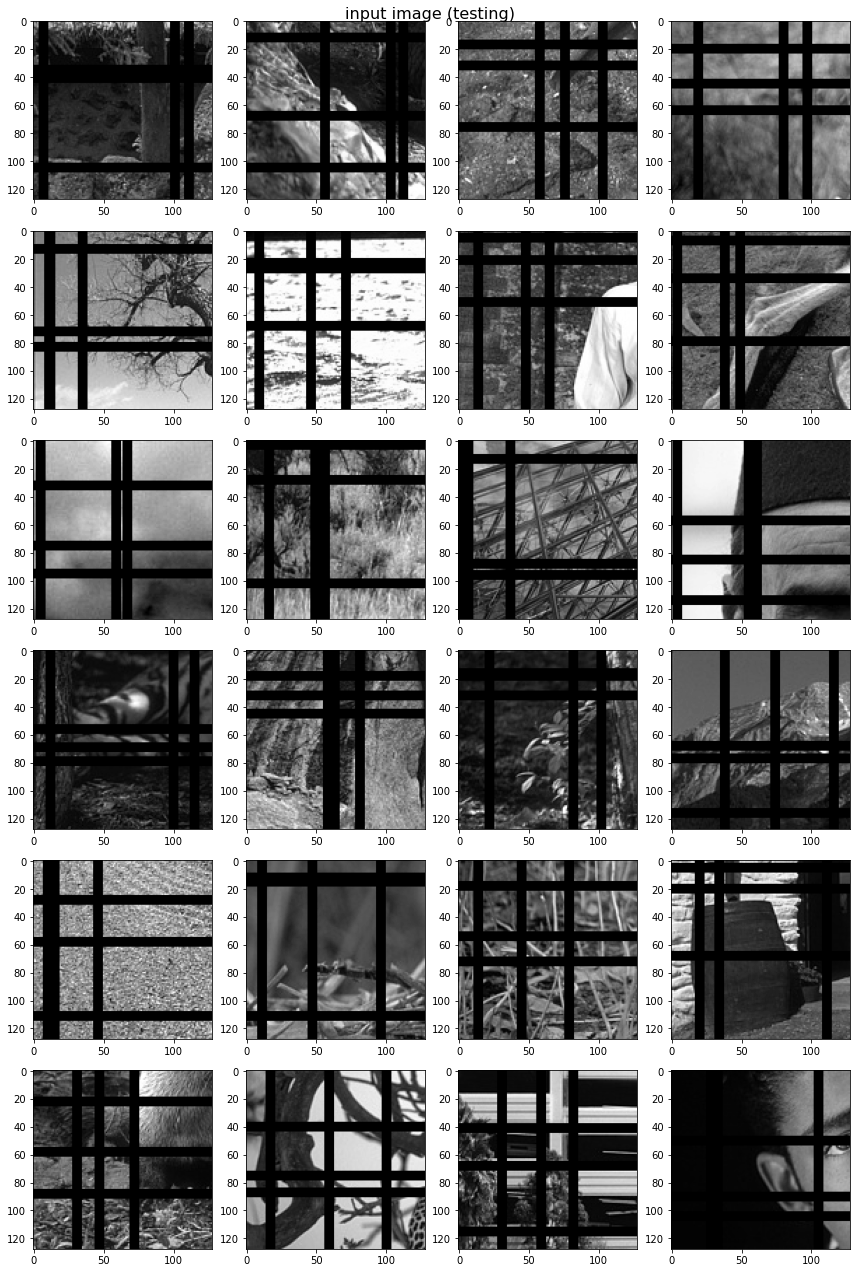

In [6]:
plot_image('input image (testing)', input_image_test)

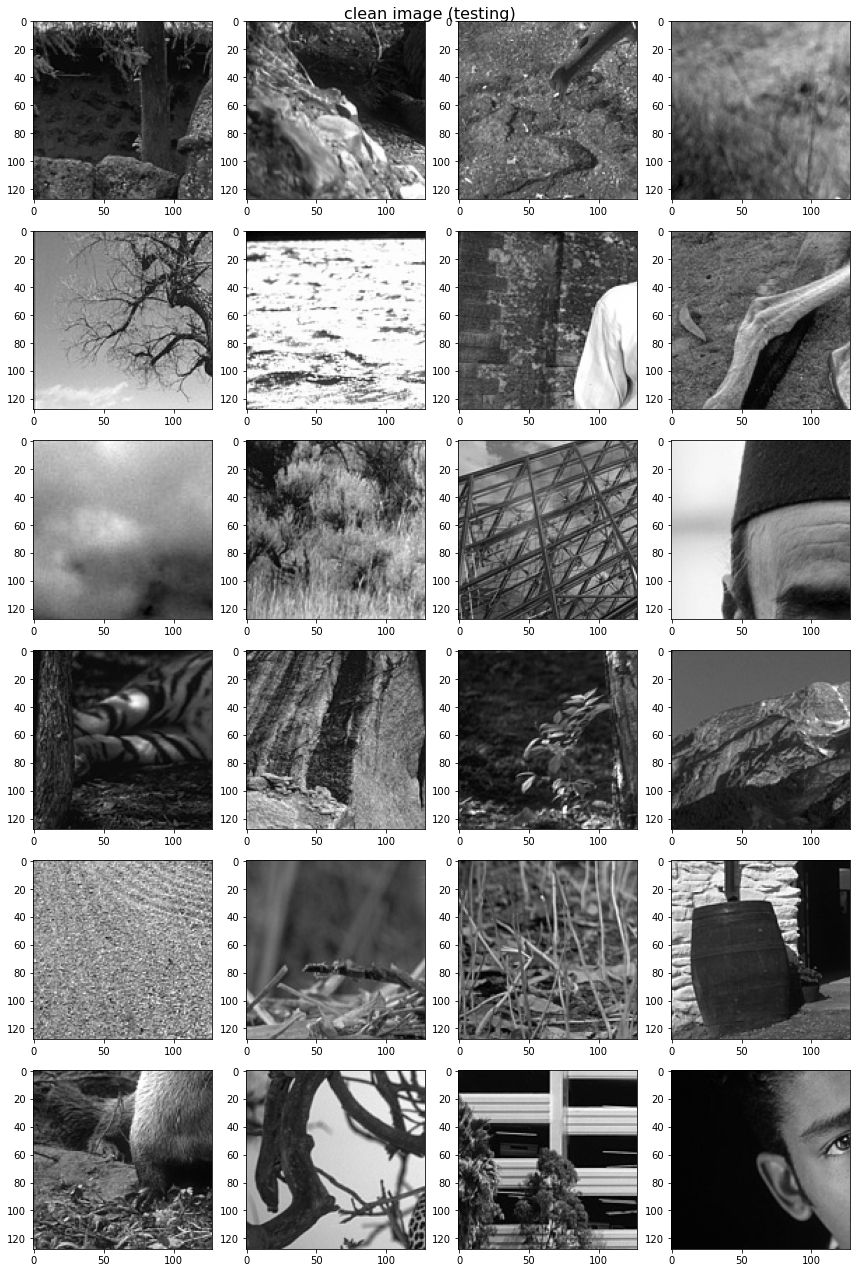

In [7]:
plot_image('clean image (testing)', clean_image_test)

## custom data loader for the training data

In [8]:
# random seed
import random
random.seed(20184757)
np.random.seed(20184757)
torch.manual_seed(20184757)
torch.cuda.manual_seed(20184757)
torch.cuda.manual_seed_all(20184757)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [9]:
class dataset(Dataset):
    
    def __init__(self, clean_image):
        
        self.clean_image = clean_image

    def __getitem__(self, index):
        # ==================================================
        # modify the codes for training data
        #        
        clean_image = self.clean_image[index]
        clean_image = torch.FloatTensor(clean_image).unsqueeze(dim=0)
        
        input_image = self.clean_image[index]
        input_image = torch.FloatTensor(input_image).unsqueeze(dim=0)
        
        input_image[:,torch.cat([torch.arange(i,i+8) for i in torch.randint(low=0, high=120, size=(3,))]),:] = 0.
        input_image[:,:,torch.cat([torch.arange(i,i+8) for i in torch.randint(low=0, high=120, size=(3,))])] = 0.

        return (input_image, clean_image)
        #    
        # ==================================================

    def __len__(self):

        number_image = self.clean_image.shape[0]

        return number_image    

## setting device

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'mps')

In [11]:
print(device)

cuda


## custom data loader for the testing data

In [12]:
input_image_test = torch.FloatTensor(input_image_test).unsqueeze(dim=1)
clean_image_test = torch.FloatTensor(clean_image_test).unsqueeze(dim=1)

input_image_test = input_image_test.to(device)
clean_image_test = clean_image_test.to(device)

## construct datasets and dataloaders for training and testing

In [13]:
# ==================================================
# determine the mini-batch size
#
size_minibatch      = 64
#
# ==================================================

dataset_train       = dataset(clean_image_train)
dataloader_train    = torch.utils.data.DataLoader(dataset_train, batch_size=size_minibatch, shuffle=True, drop_last=True)

## construct a neural network 

In [14]:
# class Network(nn.Module):
#     def __init__(self):
#         super(Network,self).__init__()

#         # -------------------------------------------------
#         # Encoder
#         # -------------------------------------------------
#         self.e_layer1 = nn.Sequential(
#             nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, stride=2, padding=1, bias=True),  
#             nn.BatchNorm2d(64),
#             nn.ReLU(),
#         )
        
#         self.e_layer2 = nn.Sequential(
#             nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2, padding=1, bias=True),
#             nn.BatchNorm2d(128),
#             nn.ReLU(),
#         )
        
#         self.e_layer3 = nn.Sequential(
#             nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=2, padding=1, bias=True),
#             nn.BatchNorm2d(256),
#             nn.ReLU(),
#         )

#         # -------------------------------------------------
#         # Decoder
#         # -------------------------------------------------
#         self.d_layer3 = nn.Sequential(
#             nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
#             nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, stride=1, padding=1, bias=True),
#             nn.BatchNorm2d(128),
#             nn.ReLU(),
#         )
        
#         self.d_layer2 = nn.Sequential(
#             nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
#             nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, stride=1, padding=1, bias=True),
#             nn.BatchNorm2d(64),
#             nn.ReLU(),
#         )
        
#         self.d_layer1 = nn.Sequential(
#             nn.Upsample(scale_factor=2, mode='bilinear', align_corners=False),
#             nn.Conv2d(in_channels=64, out_channels=1, kernel_size=3, stride=1, padding=1, bias=True),
#             nn.Sigmoid(),
#         )

#         # -------------------------------------------------
#         # Network
#         # -------------------------------------------------
#         self.network = nn.Sequential(
#             self.e_layer1,
#             self.e_layer2,
#             self.e_layer3,
#             self.d_layer3,
#             self.d_layer2,
#             self.d_layer1,
#         )

#         self.initialize_weight()

#     def forward(self,x):
    
#         out = self.network(x)
      
#         return out

#     # ======================================================================
#     # initialize weights
#     # ======================================================================
#     def initialize_weight(self):
            
#         for m in self.network.modules():
            
#             if isinstance(m, nn.Conv2d):

#                 nn.init.xavier_uniform_(m.weight) 
#                 if m.bias is not None:

#                     nn.init.constant_(m.bias, 1)
#                     pass
                    
#             elif isinstance(m, nn.BatchNorm2d):
                
#                 nn.init.constant_(m.weight, 1)
#                 nn.init.constant_(m.bias, 1)
                
#             elif isinstance(m, nn.Linear):

#                 nn.init.xavier_uniform_(m.weight)

#                 if m.bias is not None:
                    
#                     nn.init.constant_(m.bias, 1)
#                     pass


class Network(nn.Module):
    def __init__(self):
        super(Network,self).__init__()

        # -------------------------------------------------
        # Encoder
        # -------------------------------------------------
        self.encoder_layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
        )
        
#         self.down_layer1 = nn.Sequential(
#             nn.Conv2d(in_channels=64, out_channels=64, kernel_size=2, stride=2, padding=0, bias=True),
#         )
        
        self.encoder_layer2 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(),
        )
        
#         self.down_layer2 = nn.Sequential(
#             nn.Conv2d(in_channels=128, out_channels=128, kernel_size=2, stride=2, padding=0, bias=True),
#         )
        
        self.encoder_layer3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(),
        )
        
#         self.down_layer3 = nn.Sequential(
#             nn.Conv2d(in_channels=256, out_channels=256, kernel_size=2, stride=2, padding=0, bias=True),
#         )
        
        self.encoder_layer4 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(),
        )
        
        self.encoder_layer5 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=1024, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(),
        )
        
        self.down_layer = nn.Sequential(
            nn.MaxPool2d((2,2))
        )
        
#         self.encoder_layer11 = nn.Sequential(
#             nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3, stride=1, padding=1, bias=True),
#             nn.BatchNorm2d(64),
#             nn.ReLU(),
#             nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1, bias=True),
#             nn.BatchNorm2d(64),
#             nn.ReLU(),
#         )
        
#         self.encoder_layer21 = nn.Sequential(
#             nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1, bias=True),
#             nn.BatchNorm2d(128),
#             nn.ReLU(),
#             nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1, bias=True),
#             nn.BatchNorm2d(128),
#             nn.ReLU(),
#         )
        
#         self.encoder_layer31 = nn.Sequential(
#             nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1, bias=True),
#             nn.BatchNorm2d(256),
#             nn.ReLU(),
#             nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1, bias=True),
#             nn.BatchNorm2d(256),
#             nn.ReLU(),
#         )
        
#         self.encoder_layer41 = nn.Sequential(
#             nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, stride=1, padding=1, bias=True),
#             nn.BatchNorm2d(512),
#             nn.ReLU(),
#         )

        # -------------------------------------------------
        # Decoder
        # -------------------------------------------------
        
        self.decoder_layer5 = nn.Sequential(
            nn.Conv2d(in_channels=1024, out_channels=1024, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(),
        )
        
        self.up_layer4 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=1024, out_channels=512, kernel_size=2, stride=2, bias=True)
        )

        self.decoder_layer4 = nn.Sequential(
            nn.Conv2d(in_channels=1024, out_channels=512, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(),
        )
    
        self.up_layer3 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=2, stride=2, bias=True)
        )
        
        self.decoder_layer3 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(),
        )
        
        self.up_layer2 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=2, stride=2, bias=True),
        )
        
        self.decoder_layer2 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(),
        )
        
        self.up_layer1 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=2, stride=2, bias=True)
        )
        
        self.decoder_layer1 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(),
            nn.Conv2d(in_channels=64, out_channels=1, kernel_size=3, stride=1, padding=1, bias=True),
            nn.Sigmoid(),
        )
        
        
#         self.decoder_layer41 = nn.Sequential(
#             nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, stride=1, padding=1, bias=True),
#             nn.BatchNorm2d(512),
#             nn.ReLU(),
#         )
    
#         self.up_layer31 = nn.Sequential(
#             nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size=2, stride=2, bias=True)
#         )
        
#         self.decoder_layer31 = nn.Sequential(
#             nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, stride=1, padding=1, bias=True),
#             nn.BatchNorm2d(256),
#             nn.ReLU(),
#             nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1, bias=True),
#             nn.BatchNorm2d(256),
#             nn.ReLU(),
#         )
        
#         self.up_layer21 = nn.Sequential(
#             nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=2, stride=2, bias=True),
#         )
        
#         self.decoder_layer21 = nn.Sequential(
#             nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, stride=1, padding=1, bias=True),
#             nn.BatchNorm2d(128),
#             nn.ReLU(),
#             nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1, bias=True),
#             nn.BatchNorm2d(128),
#             nn.ReLU(),
#         )
        
#         self.up_layer11 = nn.Sequential(
#             nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=2, stride=2, bias=True)
#         )
        
#         self.decoder_layer11 = nn.Sequential(
#             nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, stride=1, padding=1, bias=True),
#             nn.BatchNorm2d(64),
#             nn.ReLU(),
#             nn.Conv2d(in_channels=64, out_channels=1, kernel_size=3, stride=1, padding=1, bias=True),
#             nn.Sigmoid(),
#         )

        # -------------------------------------------------
        # Network
        # -------------------------------------------------

        self.network = nn.ModuleList([
            self.encoder_layer1,
            self.encoder_layer2,
            self.encoder_layer3,
            self.encoder_layer4,
            self.encoder_layer5,
            self.down_layer,
#             self.down_layer1,
#             self.down_layer2,
#             self.down_layer3,
            self.up_layer4,
            self.up_layer3,
            self.up_layer2,
            self.up_layer1,
            self.decoder_layer5,
            self.decoder_layer4,
            self.decoder_layer3,
            self.decoder_layer2, 
            self.decoder_layer1,
            
#             self.encoder_layer11,
#             self.encoder_layer21,
#             self.encoder_layer31,
#             self.encoder_layer41,
#             self.up_layer31,
#             self.up_layer21,
#             self.up_layer11,
#             self.decoder_layer41,
#             self.decoder_layer31,
#             self.decoder_layer21, 
#             self.decoder_layer11,
        ])

        self.initialize_weight()

    def forward(self,x):

        encode1 = self.encoder_layer1(x)
#         down1 = self.down_layer1(encode1)
        down1 = self.down_layer(encode1)
        
        encode2 = self.encoder_layer2(down1)
#         down2 = self.down_layer2(encode2)
        down2 = self.down_layer(encode2)
        
        encode3 = self.encoder_layer3(down2)
#         down3 = self.down_layer3(encode3)
        down3 = self.down_layer(encode3)

        
        encode4 = self.encoder_layer4(down3)
        down4 = self.down_layer(encode4)
        
        encode5 = self.encoder_layer5(down4)
        
        decode5 = self.decoder_layer5(encode5)
        
        up4 = self.up_layer4(decode5)
        cat4 = torch.cat((up4, encode4), dim=1)
        decode4 = self.decoder_layer4(cat4)
        
        up3 = self.up_layer3(decode4)
        cat3 = torch.cat((up3, encode3), dim=1)
        decode3 = self.decoder_layer3(cat3)
        
        up2 = self.up_layer2(decode3)
        cat2 = torch.cat((up2, encode2), dim=1)
        decode2 = self.decoder_layer2(cat2)
        
        up1 = self.up_layer1(decode2)
        cat1 = torch.cat((up1, encode1), dim=1)
        out = self.decoder_layer1(cat1)
        
        
#         encode1 = self.encoder_layer11(out)
#         down1 = self.down_layer(encode1)
        
#         encode2 = self.encoder_layer21(down1)
#         down2 = self.down_layer(encode2)
        
#         encode3 = self.encoder_layer31(down2)
#         down3 = self.down_layer(encode3)

        
#         encode4 = self.encoder_layer41(down3)
        
#         decode4 = self.decoder_layer41(encode4)
        
#         up3 = self.up_layer31(decode4)
#         cat3 = torch.cat((up3, encode3), dim=1)
#         decode3 = self.decoder_layer31(cat3)
        
#         up2 = self.up_layer21(decode3)
#         cat2 = torch.cat((up2, encode2), dim=1)
#         decode2 = self.decoder_layer21(cat2)
        
#         up1 = self.up_layer11(decode2)
#         cat1 = torch.cat((up1, encode1), dim=1)
#         out = self.decoder_layer11(cat1)
        
      
        return out

    # ======================================================================
    # initialize weights
    # ======================================================================
    def initialize_weight(self):
            
        for m in self.network.modules():
            
            if isinstance(m, nn.Conv2d):

                nn.init.xavier_uniform_(m.weight) 
                if m.bias is not None:

                    nn.init.constant_(m.bias, 1)
                    pass
                    
            elif isinstance(m, nn.BatchNorm2d):
                
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 1)
                
            elif isinstance(m, nn.Linear):

                nn.init.xavier_uniform_(m.weight)

                if m.bias is not None:
                    
                    nn.init.constant_(m.bias, 1)
                    pass

## build the network

In [15]:
model = Network().to(device)

# ==================================================
# determine the optimiser and its associated hyper-parameters
#

learning_rate   = 0.001
weight_decay    = 0.0001
number_epoch    = 500
optimizer       = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
# scheduler       = torch.optim.lr_scheduler.LambdaLR(optimizer=optimizer,
#                                                     lr_lambda=lambda epoch: 0.95 ** epoch,
#                                                     verbose=False)
scheduler       = torch.optim.lr_scheduler.StepLR(optimizer=optimizer,
                                                  step_size=50,
                                                  gamma=0.5)
#
# ==================================================

## compute the prediction

In [16]:
def compute_prediction(model, input):

    prediction = model(input)

    return prediction

## compute the PSNR metric

- data1 : mini-batch-size x channel x height x width (torch tensor)
- data2 : mini-batch-size x channel x height x width (torch tensor)

In [17]:
def compute_psnr(data1, data2):

    mse         = nn.MSELoss()(data1, data2)
    mse_value   = mse.item()
    psnr        = 10 * np.log10(1 / mse_value)

    return psnr

## Variable for the learning curves

In [18]:
psnr_test = np.zeros(number_epoch)

## train

In [19]:
def train(model, optimizer, dataloader):

    model.train()

    # ==================================================
    # fill up the blank
    #

    for _, (input_image, clean_image) in enumerate(dataloader):
        
        input_image = input_image.to(device)
        clean_image = clean_image.to(device)
        
        prediction = compute_prediction(model, input_image)
        loss = nn.MSELoss()(prediction, clean_image)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    #
    # ==================================================

## test

In [20]:
def test(model, input_image, clean_image):

    model.eval()

    num_steps   = 40
    steps       = np.linspace(0, input_image.shape[0], num_steps+1).astype(int)
    psnr_steps  = np.zeros(num_steps)
    
    for i in range(num_steps):
        input           = input_image[steps[i]:steps[i+1], :, :]
        clean           = clean_image[steps[i]:steps[i+1], :, :]
        prediction      = compute_prediction(model, input)
        psnr_steps[i]   = compute_psnr(clean, prediction)
    
    psnr = psnr_steps.mean()
    
    return psnr

## train and test

In [21]:
# ================================================================================
# 
# iterations for epochs
#
# ================================================================================
for i in tqdm(range(number_epoch)):
    
    # ================================================================================
    # 
    # training
    #
    # ================================================================================
    train(model, optimizer, dataloader_train)
    
    # ================================================================================
    # 
    # testing
    #
    # ================================================================================
    psnr            = test(model, input_image_test, clean_image_test)
    psnr_test[i]    = psnr
    scheduler.step()

100%|██████████| 500/500 [30:51<00:00,  3.70s/it]


---

## functions for presenting the results

---

In [22]:
def function_result_01():
    
    title           = 'psnr (testing)'
    label_axis_x    = 'epoch' 
    label_axis_y    = 'psnr'
    
    plt.figure(figsize=(8, 6))
    plt.title(title)

    plt.plot(psnr_test, '-')
    
    plt.xlabel(label_axis_x)
    plt.ylabel(label_axis_y)

    plt.tight_layout()
    plt.show()

In [23]:
def function_result_02():
   
    nRow = 9
    nCol = 4
    size = 3
   
    title = 'testing results'
    fig, axes = plt.subplots(nRow, nCol, figsize=(size * nCol, size * nRow))
    fig.suptitle(title, fontsize=16)

    model.eval()

    num_test = 12

    input_image         = input_image_test[0:num_test]
    clean_image         = clean_image_test[0:num_test]
    prediction_image    = compute_prediction(model, input_image)
   
    input_image         = input_image.detach().cpu().squeeze(axis=1)
    clean_image         = clean_image.detach().cpu().squeeze(axis=1)
    prediction_image    = prediction_image.detach().cpu().squeeze(axis=1)

    nStep   = 3
    t       = 0
   
    for r in range(3):
        for c in range(nCol):
            k = r * nCol * 10 + c * 4 + 10
           
            input       = input_image[t].detach().cpu().squeeze(axis=1)
            clean       = clean_image[t].detach().cpu().squeeze(axis=1)
            prediction  = prediction_image[t].detach().cpu().squeeze(axis=1)
           
            axes[0 + r * nStep, c].imshow(input, cmap='gray')
            axes[1 + r * nStep, c].imshow(clean, cmap='gray', vmin=0, vmax=1)
            axes[2 + r * nStep, c].imshow(prediction, cmap='gray', vmin=0, vmax=1)

            axes[0 + r * nStep, c].xaxis.set_visible(False)
            axes[1 + r * nStep, c].xaxis.set_visible(False)
            axes[2 + r * nStep, c].xaxis.set_visible(False)
           
            axes[0 + r * nStep, c].yaxis.set_visible(False)
            axes[1 + r * nStep, c].yaxis.set_visible(False)
            axes[2 + r * nStep, c].yaxis.set_visible(False)
           
            t = t + 1
   
    plt.tight_layout()
    plt.show()

In [24]:
def function_result_03():
    
    print('final testing psnr = %9.8f' % (psnr_test[-1]))

---

## results 

---


################################################################################
#
# RESULT # 01
#
################################################################################



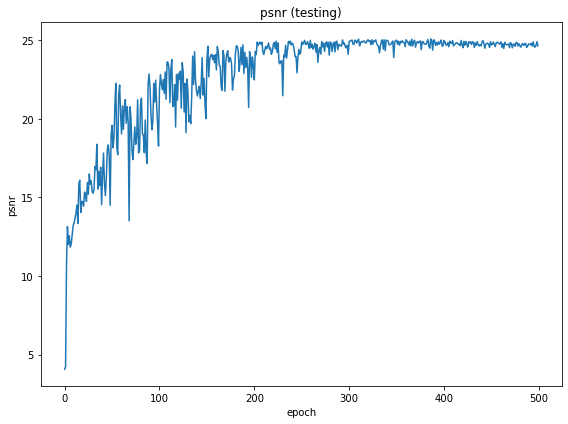


################################################################################
#
# RESULT # 02
#
################################################################################



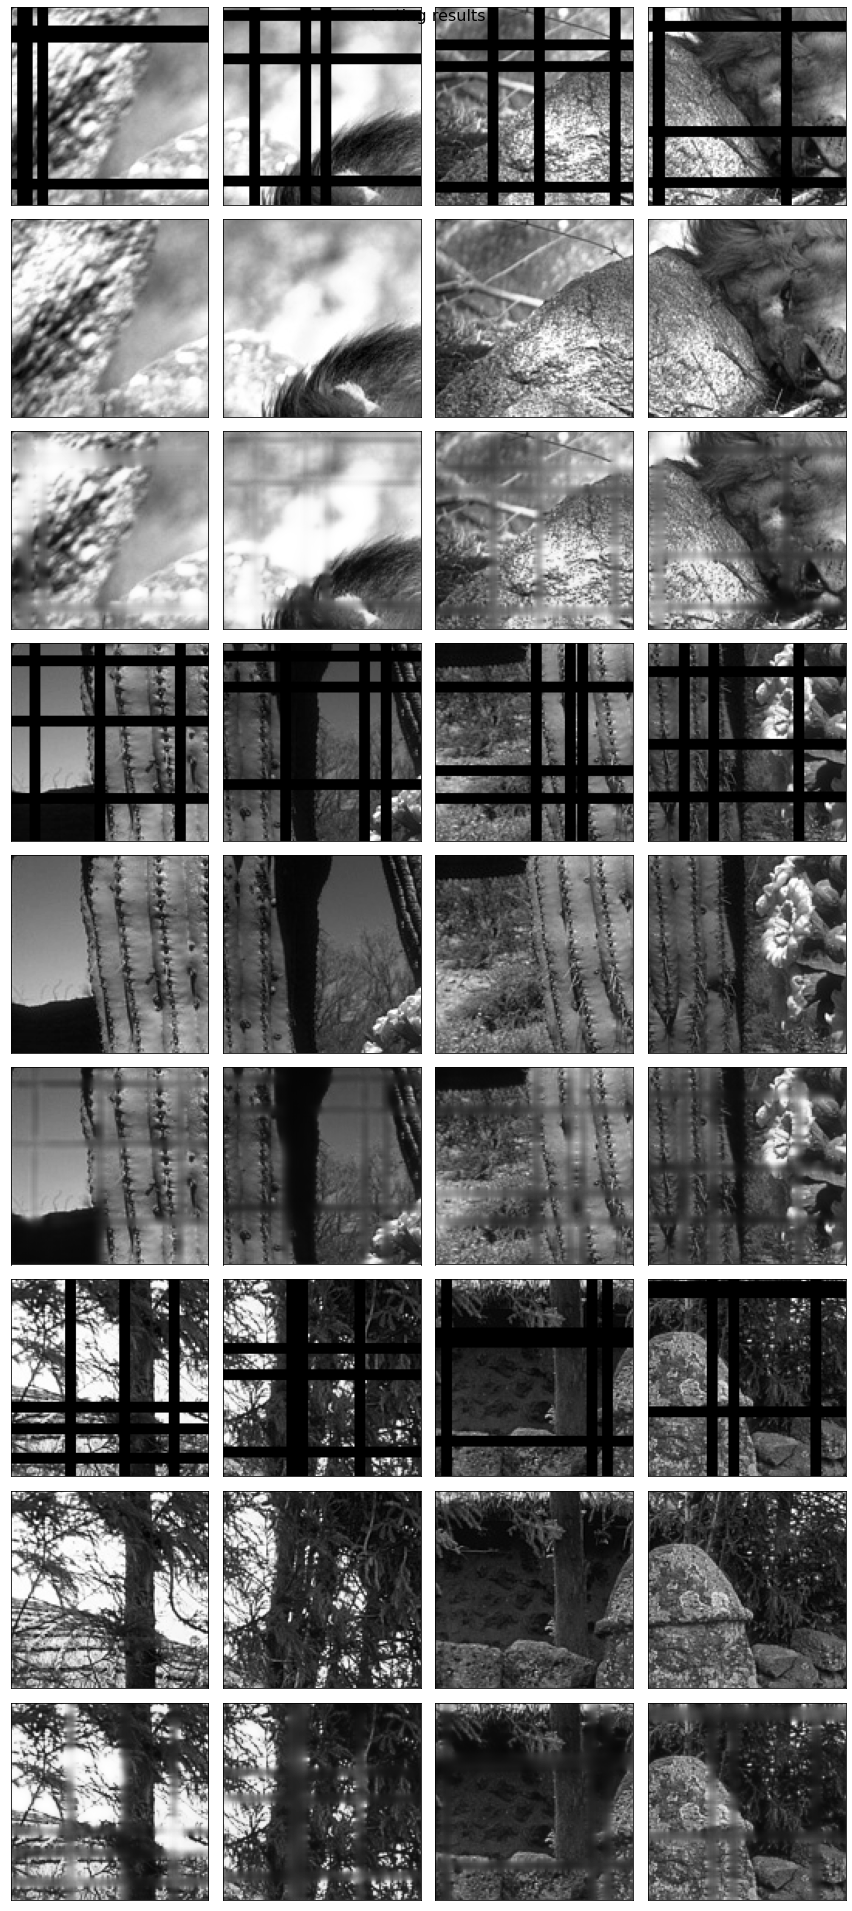


################################################################################
#
# RESULT # 03
#
################################################################################

final testing psnr = 24.63511748


In [25]:
number_result = 3 

for i in range(number_result):

    title           = '# RESULT # {:02d}'.format(i+1)
    name_function   = 'function_result_{:02d}()'.format(i+1)

    print('') 
    print('################################################################################')
    print('#') 
    print(title)
    print('#') 
    print('################################################################################')
    print('') 

    eval(name_function)

In [26]:
np.max(psnr_test), np.argmax(psnr_test)

(25.083489304274213, 386)

In [ ]:
os._exit(0)

In [ ]:
# current 25.08

In [ ]:
'''
0.001 0.0001 Adam 500 => 24.81 (452)
0.01 0.0001 Adam 500 => 24.18 (436)
0.0001 0.0001 Adam 500 => 24.94 (420)
0.01 0.0001 SGD(0.9) 100 => 22.82 (93)
                     200 => 23.48 (180)
                     300 => 23.86 (290)
                     400 => 24.05 (388)
                     500 => 24.14 (477)
0.1 0.0001 SGD(0.9) 500 => 24.76 (383)
* leaky relu
0.1 0.0001 SGD(0.9) 500 => 24.84 (459)
0.001 0.0001 Adam 500 => 24.68 (455)
0.001 0.0001 Adam(step 50 0.5) 500 => 25.08 (386)
0.1 0.0001 SGD(0.9 step 50 0.5) 500 => 23.94 (485)
'''